# Tutorial: Find an Inspiral

We try to find an inspiral from the GW data. This code is taken from the tutorial located at [Tutorial: Find an Inspiral](https://gwosc.org/tutorial06/). We first download the necessary files.

In [2]:
! wget -q -N https://gwosc.org/static/sample_code/data_w_signal.hdf5
! wget -q -N https://gwosc.org/static/sample_code/template.hdf5

In [3]:
# -- Import python data and plotting packages 
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import h5py

# -- Read the data file (16 seconds, sampled at 4096 Hz)
fs = 4096

dataFile = h5py.File('data_w_signal.hdf5', 'r')
data = dataFile['strain/Strain'][...]
dataFile.close()
time = np.arange(0, 16, 1./fs)

# -- Read the template file (1 second, sampled at 4096 Hz)
templateFile = h5py.File('template.hdf5', 'r')
template = templateFile['strain/Strain'][...]
temp_time = np.arange(0, template.size / (1.0*fs), 1./fs)
templateFile.close()

The signal is somewhere in the first 12 seconds of the data file. Our task is to try and find out where.

To get an idea of what we are working with, let's plot the data and the template: 

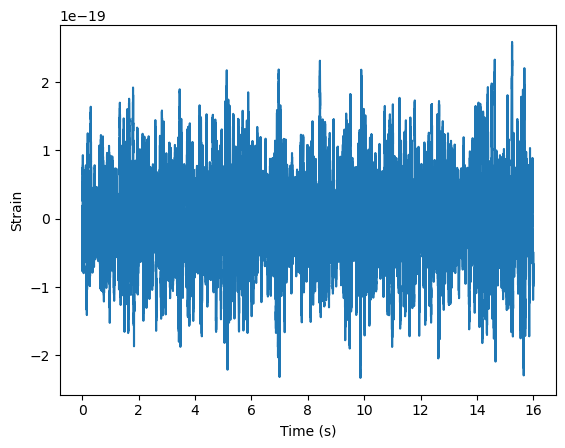

In [5]:
plt.figure()
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.savefig('./figs/fig0.pdf')

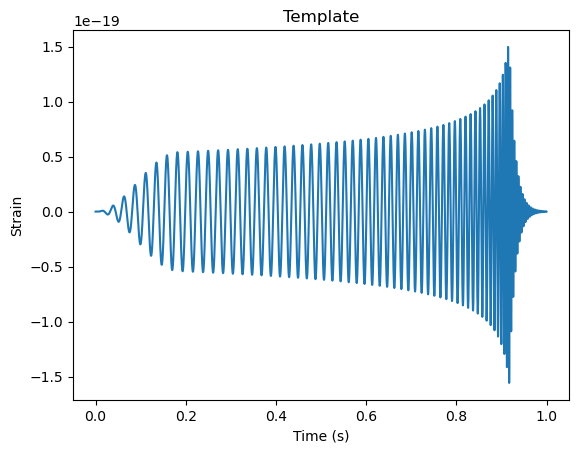

In [6]:
plt.plot(temp_time, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Template')

plt.savefig('./figs/fig1.pdf')

There are 3 methods detailed in the tutorial to find the signal: applying a bandpass filter, doing a time doman cross-correlation, and using an optimal matched filter. 

For the first one, we plot the Auto spectral discrete function (ASD) or the power spectral density function, of the signal.

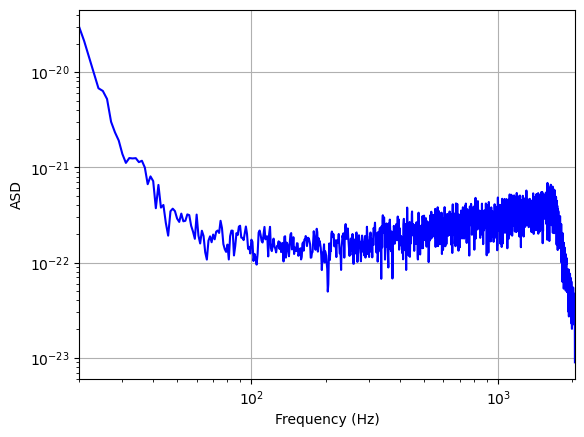

In [8]:
#------------------------
# Plot ASD of data
#-----------------------
plt.figure()
power_data, freq_psd = plt.psd(data[12*fs:], Fs=fs, NFFT=fs, visible=False)
plt.close()
plt.figure()
plt.loglog(freq_psd, np.sqrt(power_data), 'b')
plt.xlim([20, 2048])
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')

plt.savefig('figs/fig2.pdf')
plt.show()

Now we plot the ASD of the template. 

/tmp/ipykernel_690/931277166.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(freq, np.sqrt(power), 'r')


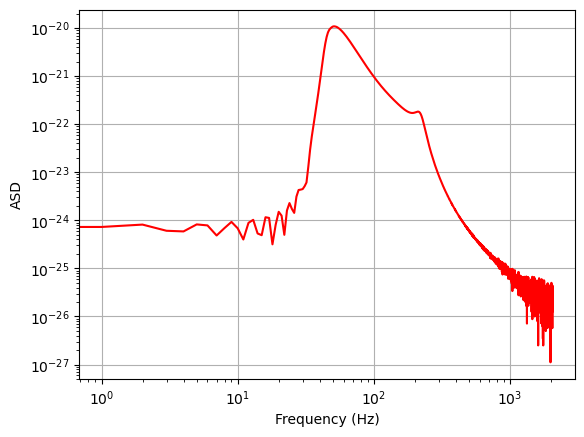

In [9]:
#----------------------
# Plot ASD of template
#----------------------
power, freq = plt.psd(template, Fs=fs, NFFT=fs, visible=False)
plt.loglog(freq, np.sqrt(power), 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')
plt.savefig('figs/fig3.pdf')
plt.show()

Finally, we apply a bandpass filter to the data

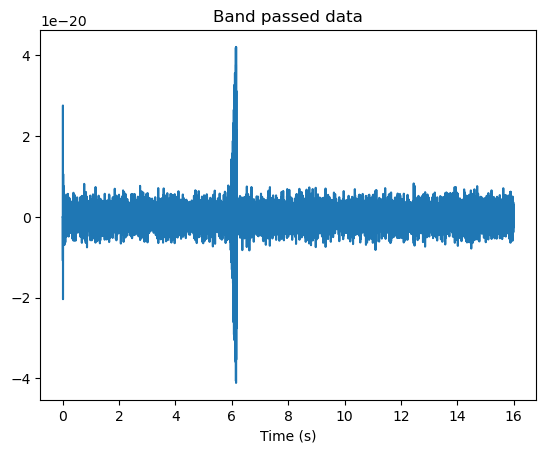

In [10]:
#-------------------------------------
# Apply a bandpass filter to the data
#------------------------------------
(B,A) = sig.butter(4, [80/(fs/2.0), 250/(fs/2.0)], btype='pass')
data_pass= sig.lfilter(B, A, data)
plt.figure()
plt.plot(time, data_pass)
plt.title('Band passed data')
plt.xlabel('Time (s)')
plt.savefig('figs/fig4.pdf')

We see that a very loud, peaked signal is visible at a bit greater than 6 seconds. 

For our next method, of time domain cross-correlation, we  take the cross-correlation of the template with the data to see if there is evidence for a match at any time-lag. We also do this for the band passed data that we got in the previous part. 

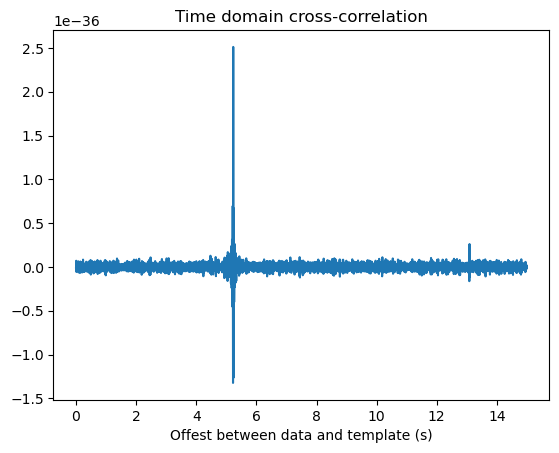

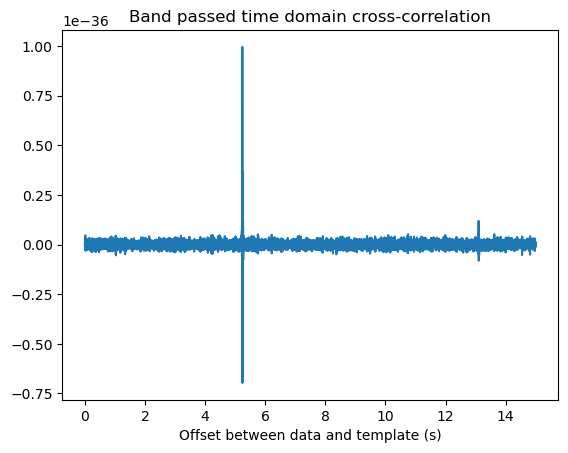

In [12]:
#------------------------------
# Time domain cross-correlation
#------------------------------
correlated_raw = np.correlate(data, template, 'valid')
correlated_passed = np.correlate(data_pass, template, 'valid')
plt.figure()
plt.plot(np.arange(0, (correlated_raw.size*1.)/fs, 1.0/fs),correlated_raw)
plt.title('Time domain cross-correlation')
plt.xlabel('Offest between data and template (s)')
plt.savefig('figs/fig5.pdf')

plt.figure()
plt.plot(np.arange(0, (correlated_passed.size*1.)/fs, 1.0/fs), correlated_passed)
plt.xlabel('Offset between data and template (s)')
plt.title('Band passed time domain cross-correlation')
plt.savefig('figs/fig6.pdf')

Finally, we perform our last method, which is to use an optimal matched filter. The way it works is by weighting the different frequency bins by their noise. We start by taking the fast fourier transform (FFT) of the data. Then we pad the template with zeroes to make it the same length and then take the FFT of that. Then we estimate the noise PSD for the data, which we can get by looking at the last 4 seconds and taking the PSD of that. 

We can multiply the Fourier Space template and data, and divide by the noise power in each frequency bin. Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain, so the result will be plotted as a function of time off-set between the template and the data. 

We normalize the matched filter output so that we expect a value of 1 at times of just noise. Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal. 

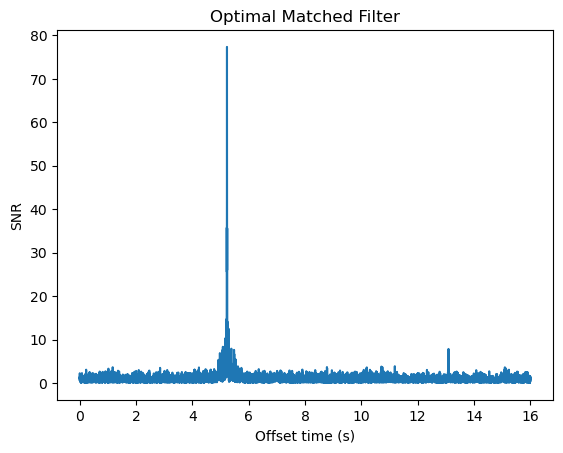

In [14]:
#-- Take the FFT of the data
data_fft=np.fft.fft(data)

#--- Pad template and take FFT
zero_pad = np.zeros(data.size - template.size)
template_padded = np.append(template, zero_pad)
template_fft = np.fft.fft(template_padded)

# --- Match FFT frequency bins to PSD frequency bins
datafreq = np.fft.fftfreq(data.size)*fs
power_vec = np.interp(datafreq, freq_psd, power_data)

# --- Apply the optimal matched filter
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)

# -- Normalize the matched filter output
df = np.abs(datafreq[1] - datafreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

# -- Plot the result
plt.figure()
plt.plot(time, SNR)
plt.title('Optimal Matched Filter')
plt.xlabel('Offset time (s)')
plt.ylabel('SNR')
plt.savefig('figs/fig7.pdf')
plt.show()

As we can see, the signal is clearly at around 5.3 or 5.4 s from the start of the data.